In [1]:
%reset -f

import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import networkx as nx

import time
import copy
import itertools

import gurobipy as gp
from gurobipy import GRB    

    
print("Cell evaluated")

Cell evaluated


In [2]:


def rand_mc(nv, deg, seed):
    # Generates a random MaxCut problem of size "nv" with degree "deg" in QUBO form.
    graph = nx.generators.random_graphs.random_regular_graph(deg, nv, seed=seed)
    matrix = nx.to_numpy_array(graph, nodelist=np.arange(nv))
    
    for k in range(nv):
        matrix[k][k] = -np.sum(matrix[k])
    
    return matrix, seed


def randsymmat5(nv, seed): 
    # Generates a random QUBO matrix with real elements
    r1 = np.random.RandomState(seed)
    matrix = np.round(r1.uniform(-1,1,size=(nv,nv)),5)
    
     # Off diagonal elements
    for i in range(nv):
        for j in range(nv):
            matrix[i][j] = matrix[j][i]
    
    if seed is None:
        pass
    else:
        r1 = np.random.RandomState(2*seed)
        
    # Diagonal elements
    for s in range(nv): 
        matrix[s][s] = np.round(r1.uniform(-1,1),5)
    return matrix, str(seed)


def solve_gurobi(matrix):
    # Faster than itertools for problem sizes 13 or bigger
    # Slower than itertools for problem sizes 12 or smaller
   
    m = gp.Model("Solve QUBO")
    x = m.addMVar(shape=len(matrix), vtype=GRB.BINARY)
    m.setMObjective(matrix, None, 0.0, x, x, None, GRB.MAXIMIZE)

    # Optimize model
#     m.setParam('TimeLimit', 120)
    m.setParam('OutputFlag', 0)
    m.optimize()
    qubo_max = m.objVal
    max_bitstr = np.array(m.X)

    m.setMObjective(matrix, None, 0.0, x, x, None, GRB.MINIMIZE)
    # Optimize model
#     m.setParam('TimeLimit', 120)
    m.setParam('OutputFlag', 0)
    m.optimize()

    qubo_min = m.objVal
    min_bitstr = np.array(m.X)
    return np.round(qubo_min,7)-1e-9,  np.round(qubo_max,7)+1e-9, min_bitstr, max_bitstr


def solve_itertools(matrix):
    # Slower than gurobi for problem sizes 13 or bigger
    # Faster than gurobi for problem sizes 12 or smaller
    
    nc = len(matrix)
    
    min_cf = 10**50
    max_cf = -10**50
    for item in itertools.product([0,1], repeat =  nc):
        bitstr = np.array(item)
        cf = (bitstr.dot(matrix)).dot(bitstr)
        
        if cf < min_cf:
            min_cf = cf
            min_bitstr = bitstr
        if cf > max_cf:
            max_cf = cf
            max_bitstr = bitstr
    
    return np.round(min_cf,7)-1e-9,  np.round(max_cf,7)+1e-9, min_bitstr, max_bitstr

def total_elem(d): 
    # Count the total number of elements in innermost list of nested dictionary. Arb depth
    return sum([total_elem(v) if isinstance(v, dict) else len(v) for v in d.values()])


print("Cell evaluated")

Cell evaluated


In [3]:
def get_hvals(matrix):
    # Obtains the Ising coefficients from the QUBO problem, NOT the 2^n by 2^n Ising Hamiltonian.
    # Faster way of doing so without any loops
    # For max cut problem, this is already written in a form to be minimized.
    # So the ground state of the resulting Hamiltonian will provide the solution to the max cut problem.
    
    # Reparameterizes the QUBO problem into {+1, -1}
    # Reparameterization done using x=(Z+1)/2
    # Minimize z.J.z + z.h + offset
    jmat =  0.25*(np.triu(matrix,k=1) + np.tril(matrix,k=-1))
    hvec = np.sum(matrix,axis=0)*0.5
    
    # Gives the correct offset value to the CF
    offset = (np.sum(matrix)/4 + np.trace(matrix)/4)
    return jmat, hvec, offset

def get_qutip_h(matrix):
    n_qubits = len(matrix)
    jj, hh, oo = get_hvals(matrix)
    
    iden_list = [qt.identity(2) for _ in range(n_qubits)]
    
    H = 0
    for nq1 in range(n_qubits):
        for nq2 in range(n_qubits):
            if nq1 == nq2:
                zi = copy.deepcopy(iden_list)
                zi[nq1] = qt.sigmaz()
                H += qt.tensor(zi) * hh[nq1]
            else:
                zizj = copy.deepcopy(iden_list)
                zizj[nq1] = qt.sigmaz() 
                zizj[nq2] = qt.sigmaz() 
                H += qt.tensor(zizj) * jj[nq1][nq2]
    H += oo
    return H
                

def cr8_mixer_h(init_bitstring): # init bitstring given in 0s and 1s
    
    init_bitstring = np.array(init_bitstring)
    n_qubits = len(init_bitstring)
    z_bitstring = 2*init_bitstring - 1
    iden_list = [qt.identity(2) for _ in range(n_qubits)]
        
    # Creates Mixer hamiltonian in x-basis
    Hx = 0
    for qq in range(n_qubits):
        xi = copy.deepcopy(iden_list)
        xi[qq] = qt.sigmax() * z_bitstring[qq]
        Hx += qt.tensor(xi)
    
    return Hx
    

def cr8_init_state(init_bitstring):
    # Creates input state from bitstring in z-basis
    init_qb_st8 = [qt.basis(2,0) if bit%2 == 0 else qt.basis(2,1) for bit in init_bitstring]    
    state = qt.tensor(init_qb_st8)
    
    return state

print("Cell evaluated")

Cell evaluated


In [11]:

my_init = np.array([0,0,0,0,0,0,0,0])                                         # Initial 0,1 values in Z-basis
myst = cr8_init_state(my_init)                                                # Create initial state in Z-basis
myxst = qt.qip.operations.hadamard_transform(len(my_init)).dag() * myst       # Apply Hadamard to initial state

# matt = rand_mc(len(my_init), 3, 1244)[0]                                    # Create initial max cut problem
matt = randsymmat5(len(my_init), 4423)[0]                                     # Create random QUBO problem
matmin, matmax, min_bitstr, max_bitsr = solve_gurobi(matt)                    # Solve using Gurobi
print("Classical sol. Min: %.3f, Max: %.3f" %(matmin, matmax))


init_h = cr8_mixer_h(my_init)                                                 # Create initial Hamiltonian (x-basis)
target_h = get_qutip_h(matt)                                                  # Create problem Hamiltonian (z-basis)

tot_time = 1000                                                               # Annealing time
timesteps = 10                                                                # Number of timesteps for evolution

options = qt.Options(nsteps=5e4)
t = np.linspace(0, tot_time, timesteps)
# Hlist = [[init_h, str(tot_time) + " - t"], [target_h, "t"]]                    # Total annealing Hamiltonian
Hlist = [[init_h, "1 - (t/"+str(tot_time)+")"], [target_h, "t/"+str(tot_time)]]  # Total annealing Hamiltonian (norm)

print()
print("Begin anneal")
anneal_state = qt.mesolve(Hlist, myxst, t, e_ops = [], options = options)
print("Annealing complete. Solution:")
fstate = anneal_state.states[-1]    
fstate.dag() * target_h * fstate

Classical sol. Min: -5.525, Max: 11.326

Begin anneal
Annealing complete. Solution:


Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[-5.52475619]]

Calculating eigenvalues during each annealing timestep...
Current iter: 20, Time elapsed: 1.42, Time left: 5.36
Current iter: 40, Time elapsed: 2.81, Time left: 4.04
Current iter: 60, Time elapsed: 4.43, Time left: 2.83
Current iter: 80, Time elapsed: 5.82, Time left: 1.37
Minimum energy gap 0.41839089999999945


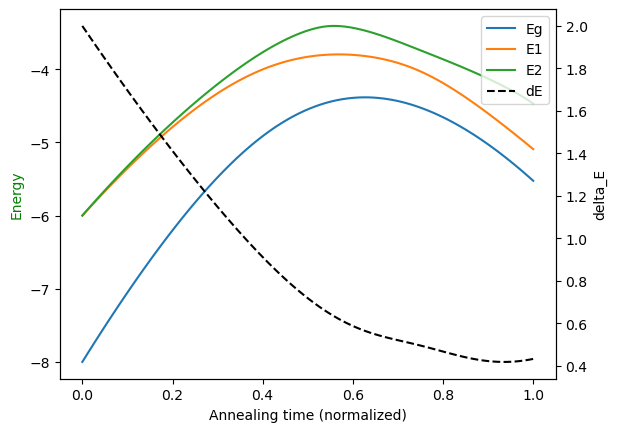

Text(0.5, 1.0, 'gap difference normalized to max and min eigvals')

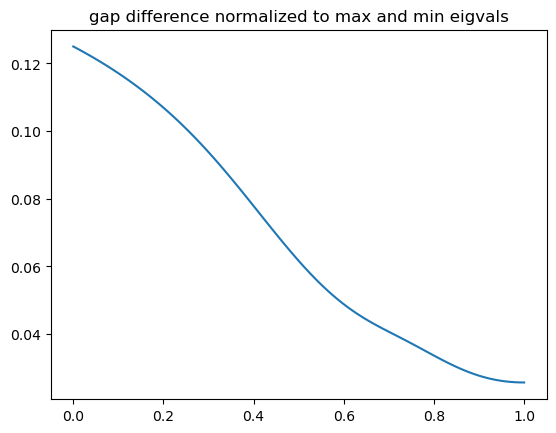

In [5]:

def total_ham(init_hamiltonian, target_hamiltonian, time, tmax):
    # normalized
    # H(s) = (1-s)*H_x + s*H_p 
    
    H_t = init_hamiltonian*(1 - time/tmax) + (time/tmax) * target_hamiltonian
    return H_t.tidyup()

    
tot_time = 1000
nsteps = 100
tt = np.linspace(0, tot_time, nsteps)

de_list = []
wde_list = []
e0_list = []
e1_list = []
e2_list = []

print("Calculating eigenvalues during each annealing timestep...")
tt1 = time.time()

for t_ in range(len(tt)):
    my_h = total_ham(init_h, target_h, tt[t_], tot_time)             # H(s) = (1-s)*H_x + s*H_p 
    ww, v = np.linalg.eig(my_h)                                      # Find eigenvalues of H(s)
    
    w_qobj = qt.Qobj(ww).tidyup()                                    # Tidy up small values
    w_numpy = w_qobj.full().reshape(1,-1)[0]
    w_numpy = np.round(copy.deepcopy(w_numpy), 7)
    e0, e1, e2 = sorted(w_numpy)[:3]                                 # Removes degeneracies and finds E_0 and E_1
    
    de = np.abs(e1 - e0)                                             # Calculates delta_E
    de_list.append(de)
    
    emax = max(set(w_numpy))                                         # Largest E value
    wde = np.abs(de/(emax -  e0))                                    # Annealing gap (normalized)
    wde_list.append(wde)
    
    e0_list.append(np.real(e0))
    e1_list.append(np.real(e1))
    e2_list.append(np.real(e2))
    
    if t_%20==0 and t_>1:
        time_elpased = time.time() - tt1
        time_per_iter = time_elpased/(t_ + 1)
        time_left = time_per_iter*(len(tt)-(t_+1))
        print("Current iter: %.d, Time elapsed: %.2f, Time left: %.2f" %(t_, time_elpased, time_left))
    
print("Minimum energy gap", min(de_list))

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(tt/tot_time, e0_list, label='Eg')
ax1.plot(tt/tot_time, e1_list, label='E1')
ax1.plot(tt/tot_time, e2_list, label="E2")
ax2.plot(tt/tot_time, de_list, color='black', linestyle='dashed', label="dE")

ax1.set_xlabel('Annealing time (normalized)')
ax1.set_ylabel('Energy', color='g')
ax2.set_ylabel('delta_E', color='black')
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax2.transAxes)

plt.pause(0.01)
plt.plot(tt/tot_time, wde_list)
plt.title("gap difference normalized to max and min eigvals")
